In [1]:
import sklearn.datasets
import numpy as np
from sklearn.model_selection import train_test_split

N = 300
noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def plot_decision_boundary(model, X, y):    
    assert (X.shape == (2, X.shape[1]) ) , "Shape is incorrect:" + str(X.shape)
    assert (y.shape == (1, y.shape[1]) ) , "Shape is incorrect:" + str(y.shape)

    import matplotlib.pyplot as plt 
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    
    # can hardcode reshaping because there is assert control
    Z = np.array([model.predict(np.array(x).reshape(2,1)) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [4]:
X_moons_all = np.array(noisy_moons[0])
Y_moons_all = np.array(noisy_moons[1])

X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons_all, Y_moons_all, test_size=0.10, random_state=42)

X_train_moons = X_train_moons.reshape(-1 , X_train_moons.shape[1]).T
X_test_moons = X_test_moons.reshape(-1, X_test_moons.shape[1]).T
y_train_moons = np.array(y_train_moons).reshape(1,-1)
y_test_moons = np.array(y_test_moons).reshape(1,-1)

print (X_train_moons.shape)
print (X_test_moons.shape)
print (y_train_moons.shape)
print (y_test_moons.shape)

(2, 270)
(2, 30)
(1, 270)
(1, 30)


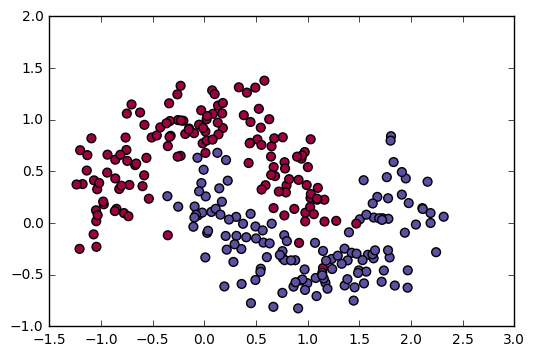

In [5]:
# Visualize the data:
plt.scatter(X_train_moons[0, :], X_train_moons[1, :], c=y_train_moons, s=40, cmap=plt.cm.Spectral);

In [46]:
def sigmoid(z):
        return 1.0 / (1 + np.exp(-z))

def sigmoid_derivate(z):
    return sigmoid(z) * (1 - sigmoid(z))

def relu(z):
    return np.maximum(z, 0)

def relu_derivate(z):
    return 0 if z <=0 else 1

class GeneralNN:
    def __init__(self, layers = [4,3,1], function_layers = [{"f" : relu, "f_der" : relu_derivate},
                                                            {"f" : relu, "f_der" : relu_derivate},
                                                            {"f" : sigmoid, "f_der" : sigmoid_derivate}]):
        '''
            layers = the list of numbers saying dimension of our NN
            types_layers = the list of tuples saying which activation function we will use
        '''
        self.layers = layers
        self.function_layers = function_layers    
        
    def init_weight_biases(self, num_features):
        self.params = {}
        
        self.params["W0"] = np.random.randn(self.layers[0], num_features) * 0.01
        self.params["b0"] = np.zeros((self.layers[0], 1))
        
        for ith in range(1, len(self.layers)):
            self.params["W" + str(ith)] = np.random.randn(self.layers[ith], self.layers[ith - 1]) * 0.01
            self.params["b" + str(ith)] = np.zeros((self.layers[ith], 1))                                 
    
    
    def predict(self, X):
        self.z_values = {} # Linear part
        self.a_values = {} # Non-linear part
        
        a_prev = X
        num_layers = len(self.layers) 
        self.z_values["z0"] = X
        self.z_values["a0"] = X
        
        for ith in range(0, num_layers):
            W = self.params["W" + str(ith)]
            b = self.params["b" + str(ith)]
            
            z_temp = np.dot(W, a_prev) + b
            a_temp = self.function_layers[ith]["f"](z_temp)
            
            # cache value
            self.z_values["z" + str(ith + 1)] = z_temp
            self.a_values["a" + str(ith + 1)] = a_temp
            a_prev = a_temp                                              
        
        return self.a_values["a" + str(num_layers)]
                                    
        
    def backward_propagation(self, A, Y):
        self.grads = {}
        num_layers = len(self.layers) 
        
        dLa = (np.divide(Y, A) - np.divide(1 - Y, 1 - A))
        self.grads["da" + str(num_layers)] = dLa
        
        da = self.grads["da" + str(num_layers)]
        z_cache = self.z_values["z" + str(num_layers)]
        self.grads["dz" + str(num_layers)] = da * (self.function_layers[num_layers - 1]["f_der"])(z_cache)
            
        for ith in reversed(range(1, num_layers)):
            print (ith)
            # da_ith = dz_ith+1 * dz_ith+1/da_ith
            # z_ith = W_ith-1 * a_ith-1 + b_ith-1
            # dz_ith+1/da_ith = W_ith
            dz = self.grads["dz" + str(ith + 1)]
            w_cache = self.params["W" + str(ith)] 
            self.grads["da" + str(ith)] = np.dot(w_cache.T, dz)
            
            da = self.grads["da" + str(ith)]
            z_cache = self.z_values["z" + str(ith)]
            self.grads["dz" + str(ith)] = da * (self.function_layers[ith - 1]["f_der"])(z_cache)
        
        da = self.grads["da0"]
        z_cache = self.z_values["z0"]
        self.grads["dz0"] = da * self.function_layers[0]["f_der"](z_cache)
   
    def update_values(self, learning_rate):
        num_layers = len(self.layers) 
        
        for ith in reversed(range(0, num_layers)):
            self.grads["dw" + str(ith)] = self.grads["dz" + str(ith)] * self.a_values["a" + str(ith)]
            self.grads["db" + str(ith)] = self.grads["dz" + str(ith)]
        
        for ith in range(0, num_layers):
            self.params["W" + str(ith)] = self.params["W" + str(ith)] + learning_rate * self.grads["dw" + str(ith)]
            self.params["b" + str(ith)] = self.params["b" + str(ith)] + learning_rate * self.grads["db" + str(ith)]
    
    def train(self, X, y, num_iteration=100, learning_rate=0.01):
        num_features = X.shape[0]
        
        self.init_weight_biases(num_features)
        for ith in range(num_iteration):
            A = self.predict(X)
            self.backward_propagation(A,y)
            self.update_values(learning_rate)
            
            
            

In [47]:
[x for x in range(2)]

[0, 1]

In [48]:
X_train_moons.shape

(2, 270)

In [49]:
nn = GeneralNN()
param = nn.train(np.array(X_train_moons) ,np.array(y_train_moons))

2


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
plt.scatter(X_train_moons[0, :], X_train_moons[1, :], c=y_train_moons, s=40, cmap=plt.cm.Spectral);

In [ ]:
plot_decision_boundary(nn, X_test_moons, y_test_moons)

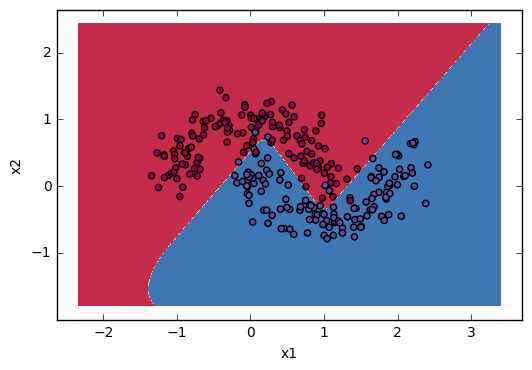

In [77]:
plot_decision_boundary(nn, X_train_moons, y_train_moons)

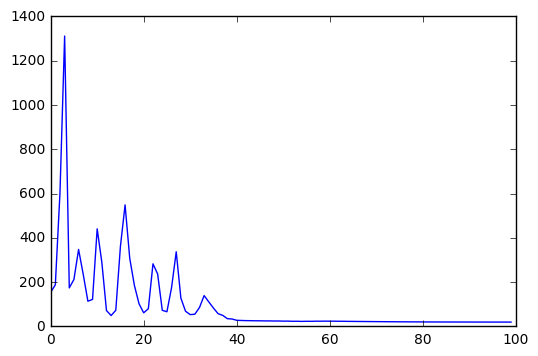

In [80]:
plt.plot(param["costs"][:100])

In [42]:
N = 400
noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    
X_circles_all = np.array(noisy_circles[0])
Y_circles_all = np.array(noisy_circles[1])

X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(X_circles_all, Y_circles_all, test_size=0.33, random_state=42)

X_train_circles = X_train_circles.reshape(-1 , X_train_circles.shape[1]).T
X_test_circles = X_test_circles.reshape(-1, X_test_circles.shape[1]).T
y_train_circles = np.array(y_train_circles).reshape(1,-1)
y_test_circles = np.array(y_test_circles).reshape(1,-1)

print (X_train_circles.shape)
print (X_test_circles.shape)
print (y_train_circles.shape)
print (y_test_circles.shape)

nn = TwoLayerNN()
param = nn.train(np.array(X_train_circles) ,np.array(y_train_circles), num_iteration=10000)

(2, 268)
(2, 132)
(1, 268)
(1, 132)
(2, 268)


{'W1': array([[ 11.92298859,  17.57047446],
        [-45.79133753,   6.41725957],
        [-17.17855864, -46.03052223],
        [-19.17584455,  18.96613875]]),
 'W2': array([[ 0.89126466, -3.90434252,  4.43843536,  3.80250832]]),
 'b1': array([[  3.76644964],
        [-22.79819228],
        [ 25.70235625],
        [ 12.77751359]]),
 'b2': array([[-2.82991541]])}

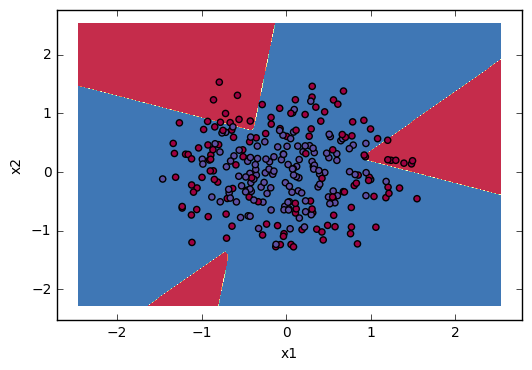

In [43]:
plot_decision_boundary(nn, X_train_circles, y_train_circles)

(2, 268)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in multiply


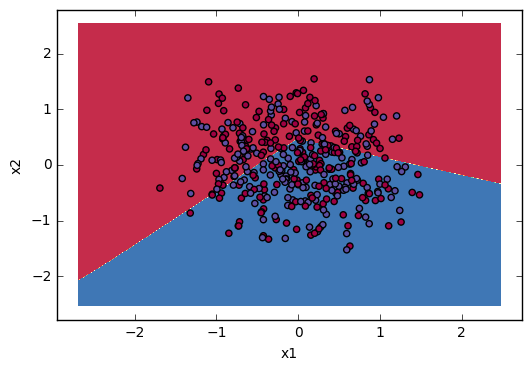

In [72]:
nn = TwoLayerNN(6)
nn.train(np.array(X_train_circles) ,np.array(y_train_circles), num_iteration=1000)
plot_decision_boundary(nn, X_circles_all.reshape(2, -1) , Y_circles_all.reshape(1,-1))

(2, 268)


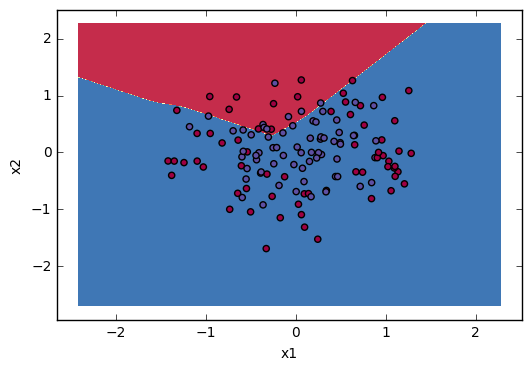

In [68]:
nn = TwoLayerNN(8)
nn.train(np.array(X_train_circles) ,np.array(y_train_circles), num_iteration=10000)
plot_decision_boundary(nn, X_test_circles, y_test_circles)